In [29]:
import h5py
import pickle
import os
from tqdm.notebook import tqdm  # For progressbar

#Computation
import numpy as np
import gudhi as gd
import pandas as pd
from numpy import inf
import scipy
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA  # for PCA
from sklearn.model_selection import train_test_split


#Plotting Packages/Settings
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
from scipy import ndimage
import matplotlib
import seaborn as sns
sns.set()
sns.set_context("talk", font_scale = 1.5)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams.update({'figure.autolayout': True})

The following code loads all data from MD simulation files.

In [30]:
#%% LOADING ALL INSTANCES
instances = np.load("MD_Training_Sets.pickle",allow_pickle = True)
test_instances = np.load("MD_Test_Sets.pickle",allow_pickle = True)

In [31]:
x_data = instances[0]
y_data = instances[1]
x_tdata = test_instances[0]
y_tdata = test_instances[1]

In [32]:
x_array = np.asarray(x_data)
x_tarray = np.asarray(x_tdata)

In [33]:
y_data = np.asarray(y_data)
y_tarray = np.asarray(y_tdata)

The following code creates the persistence diagram function as well as the smoothing function for the persistence diagrams.

In [34]:
def Create_Laplacian_Functions(grid_size,maximum,minimum):
    bins = np.arange(minimum,maximum,grid_size)
    tpoints = [] 
    weights = []
    for i in range(len(bins)-1):
        for j in range(i):
            tpoints.append([j,i])       
    tpoints = np.vstack(tpoints)
    #Create Eigenfunctions
    distmat = scipy.spatial.distance.squareform(pdist(tpoints))
    Adj = (distmat <= 3)
    Adj = Adj.astype(np.int)
    D = np.diag(np.sum(Adj,axis = 1))
    L = D - Adj
    w,v = np.linalg.eig(L)
    return w,v,tpoints,bins

w,v,tpoints,bins = Create_Laplacian_Functions(.007,.4,0)

In [35]:
def pers_intervals(data,Hdim,inv):
    intervals = []
    data = (data - np.min(data))/(np.max(data) - np.min(data))
    if inv == 1:
        x_inv = np.absolute(data - np.max(data))
        cubeplex = gd.CubicalComplex(dimensions = [np.shape(data)[0],np.shape(data)[0],np.shape(data)[0]],top_dimensional_cells=np.ndarray.flatten(x_inv))
    else:
        cubeplex = gd.CubicalComplex(dimensions = [np.shape(data)[0],np.shape(data)[0],np.shape(data)[0]],top_dimensional_cells=np.ndarray.flatten(data))
    store = cubeplex.persistence()
    pers = cubeplex.persistence_intervals_in_dimension(Hdim)
    pers[pers == inf] = np.max(data)
    intervals.append(pers) 
    return intervals

def Create_Graphs(dots,bins,weight):   
    ftime = []    
    hist = np.histogram2d(dots[:,0],dots[:,1],bins = bins)   
    hist = hist[0]
    f = []   
    if weight == 1:       
        for i in range(len(bins)-1):
            for j in range(i):
                c = np.abs(i - j)/2 + j                
                weight = (np.sqrt((i-c)**2 + (j-c)**2))                
                f.append(hist[j,i]*weight)        
        ftime.append(f)    
    else:        
        for i in range(len(bins)-1):
            for j in range(i):                
                f.append(hist[j,i])       
        ftime.append(f)
    return ftime

def Diffuse_graphs(w,v,ftime,sigma,tpoints):   
    diffusers = []  
    for f in ftime:    
        deg = len(tpoints)       
        fnew = np.asarray(f)             
        exp = np.zeros(len(fnew))        
        for i in range(deg):
            coef = np.matmul(np.transpose(v[:,i]),fnew)/(len(fnew))
            four = np.exp(-w[i]*sigma)*coef*v[:,i]
            exp = exp + four         
        exp = exp/exp.max()        
        diffusers.append(exp)    
    return diffusers

def pd_vectors(data,inv,sigma,samples,hdim,weight,y_data,instindx):
    pdvects = []
    label = []
    for i in tqdm(range(samples)):
        interval = pers_intervals(data[i],hdim,inv)
        ftime = Create_Graphs(np.vstack(interval),bins,weight)
        diff = Diffuse_graphs(w,v,ftime,sigma,tpoints)
        diff = (diff - np.min(diff))/(np.max(diff) - np.min(diff))
        pdvects.append(diff)
        label.append(y_data[instindx])
        
    return pdvects,label

Here we incorporate both the water density and the central molecule density into the data.

In [36]:
CEL = x_array[4,:,:,:,:,0] + x_array[4,:,:,:,:,1]
ETBE = x_array[15,:,:,:,:,0]+x_array[15,:,:,:,:,1]
FRU = x_array[27,:,:,:,:,0]+x_array[27,:,:,:,:,1]
LGA = x_array[38,:,:,:,:,0]+x_array[38,:,:,:,:,1]
XYL = x_array[58,:,:,:,:,0]+x_array[58,:,:,:,:,1]
PDO = x_array[48,:,:,:,:,0]+x_array[48,:,:,:,:,1]
TBU = x_array[69,:,:,:,:,0]+x_array[69,:,:,:,:,1]
FRU_t = x_tarray[3,:,:,:,:,0] + x_tarray[3,:,:,:,:,1]

Here we create all the associated persistence diagrams and their smoothed reprsentations.

In [37]:
sigma = .2
samples = 10
hdim = 2
weight = 0
inv = 0
CEL_vects,CEL_label = pd_vectors(CEL,inv,sigma,samples,hdim,weight,y_data,4)
ETBE_vects,ETBE_label = pd_vectors(ETBE,sigma,inv,samples,hdim,weight,y_data,15)
FRU_vects,FRU_label = pd_vectors(FRU,sigma,inv,samples,hdim,weight,y_data,27)
LGA_vects,LGA_label = pd_vectors(LGA,sigma,inv,samples,hdim,weight,y_data,38)
XYL_vects,XYL_label = pd_vectors(XYL,sigma,inv,samples,hdim,weight,y_data,58)
PDO_vects,PDO_label = pd_vectors(PDO,sigma,inv,samples,hdim,weight,y_data,48)
TBU_vects,TBU_label = pd_vectors(TBU,sigma,inv,samples,hdim,weight,y_data,69)
FRU_tvects,FRU_tlabel = pd_vectors(FRU_t,sigma,inv,samples,hdim,weight,y_data,3)

CEL_vects = np.vstack(CEL_vects)
ETBE_vects = np.vstack(ETBE_vects)
FRU_vects = np.vstack(FRU_vects)
LGA_vects = np.vstack(LGA_vects)
PDO_vects = np.vstack(PDO_vects)
XYL_vects = np.vstack(XYL_vects)
TBU_vects = np.vstack(TBU_vects)
FRU_tvects = np.vstack(FRU_tvects)


labels = np.hstack([ETBE_label,FRU_label,LGA_label,XYL_label,PDO_label,TBU_label,CEL_label])
allvects = np.vstack([ETBE_vects,FRU_vects,LGA_vects,XYL_vects,PDO_vects,TBU_vects,CEL_vects])
temp = [343,343,343,343,343,343,343,343,343,343,373,373,373,373,373,373,373,373,373,373,403,403,403,403,403,403,403,403,403,403,403,403,403,403,403,403,403,403,403,403,433,433,433,433,433,433,433,433,433,433,363,363,363,363,363,363,363,363,363,363]



PCA projection of smoothed diagrams.

Text(0, 0.5, 'Principal Component 2')

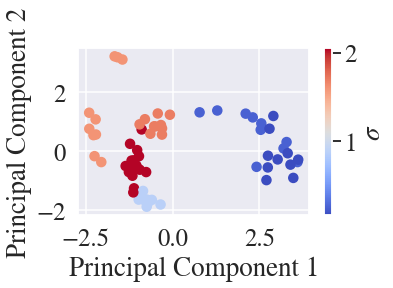

In [38]:
pca = PCA()
X = pca.fit_transform(allvects)
plt.figure()
plt.scatter(X[:,0],X[:,1], c = labels, cmap = "coolwarm")

plt.colorbar().set_label("$\sigma$")
coef = pca.components_

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")


Train and predict SVM model.

0.19880119754510941

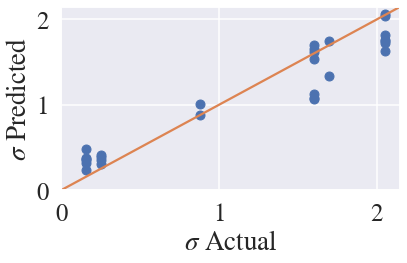

In [39]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(allvects,labels,test_size = .4)

from sklearn.svm import SVR

mdl = SVR(kernel = "rbf",C = 1)

mdl.fit(x_train,y_train)

a = mdl.predict(x_test)

plt.figure()

plt.plot(y_test,a,'o',label = "Data")

plt.plot([0,2.15],[0,2.15],label = "Identity Line")

plt.xlim([0,2.15])
plt.ylim([0,2.15])

plt.ylabel("$\sigma$ Predicted")
plt.xlabel("$\sigma$ Actual")


plt.savefig("regression2.eps")

mse = np.absolute(a - y_test)

np.sum(mse)/len(y_test)



PLot 3D Representation of density.

In [40]:
import plotly.graph_objects as go
import numpy as np

In [41]:
X, Y, Z = np.mgrid[0:1:20j, 0:1:20j, 0:1:20j]
c = x_array[15,5,:,:,:,0]

In [42]:
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=c.flatten(),
    isomin=0,
    isomax=.06,
    opacity=.03, # needs to be small to see through all surfaces
    surface_count=40, # needs to be a large number for good volume rendering
    colorscale = "RdBu_r"
))


fig.update_layout(
    autosize=False,
    width=900,
    height=700)

camera = dict(
    eye=dict(x=2, y=2, z=1)
)

fig.update_layout(scene_camera=camera)
fig.show()